<a href="https://colab.research.google.com/github/mattemugno/Smart-Waste-Classifation/blob/main/Inception_Layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Inception Layer

##Introduction

An inception network is a deep neural network with an architectural design that consists of repeating components referred to as Inception modules. The modules were designed to solve the problem of computational expense, as well as overfitting, among other issues. The solution, in short, is to take multiple kernel filter sizes within the CNN, and rather than stacking them sequentially, ordering them to operate on the same level. 

In this notebook, we will use this technique to train our CNN and compare the results with the previous models we have built.

##How it works

Inception Modules are incorporated into convolutional neural networks (CNNs) as a way of reducing computational expense. As a neural net deals with a vast array of images, with wide variation in the featured image content, also known as the salient parts, they need to be designed appropriately. The most simplified version of an inception module works by performing a convolution on an input with not one, but three different sizes of filters (1x1, 3x3, 5x5). Also, max pooling is performed. Then, the resulting outputs are concatenated and sent to the next layer. By structuring the CNN to perform its convolutions on the same level, the network gets progressively wider, not deeper. 

This is the structure of a basic Inception Module:

* Input layer
* 1x1 convolution layer
* 3x3 convolution layer
* 5x5 convolution layer
* Max pooling layer
* Concatenation layer

Below you can see the architecture of a Naive Inception Module:

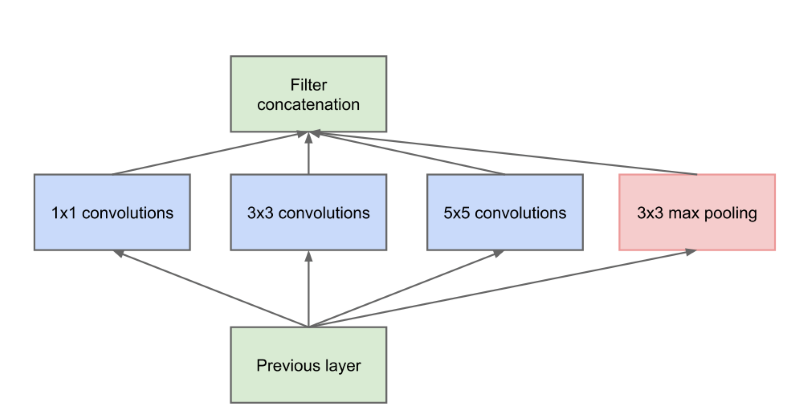

To make the process even less computationally expensive, the neural network can be designed to add an extra 1x1 convolution before the 3x3 ad 5x5 layers. By doing so, the number of input channels is limited and 1x1 convolutions are far cheaper than 5x5 convolutions. It is important to note, however, that the 1x1 convolution is added after the max-pooling layer, rather than before. 

This is the complete Inception module, with the addition of 1x1 convolutional layers: 

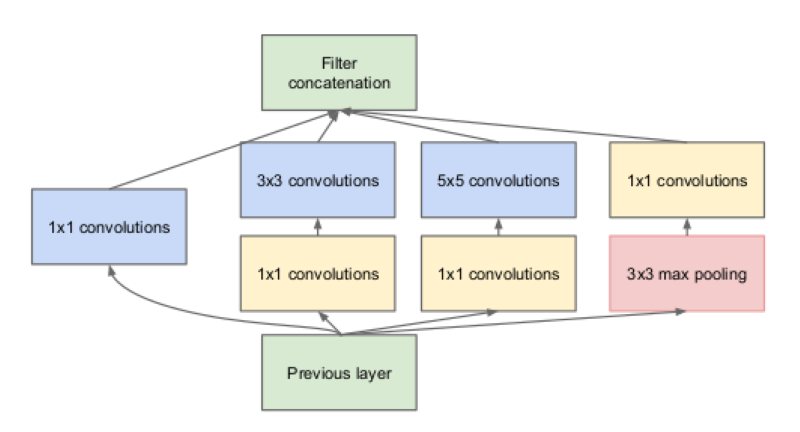

In this way, we decrease by far the computational cost within the Inception Module, reducing depth in input and the number of multiplication operations.
Now we will show the implementation of this two architectures.

#Setup

## Import libraries

In [1]:
import os
from google.colab import drive
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import *
import numpy as np
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import datetime

## Unzip preprocessed dataset

In [2]:
drive.mount('/content/drive/', force_remount=True)
!unzip -q "/content/drive/My Drive/project/SplittedDataset.zip" -d "/content/dataset/"

Mounted at /content/drive/


## Parameters definition


Definition of the paths for each dataset and choice of the size to be used for the images.

In [9]:
dataset_path = "/content/dataset/content/splitted_dataset"

training_path = os.path.join(dataset_path, "training_set")
validation_path = os.path.join(dataset_path, "validation_set")
test_path = os.path.join(dataset_path, "test_set")

models_path = "/content/drive/My Drive/project/models"
if not os.path.exists(models_path):
  os.makedirs(models_path)

In [10]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
BATCH_SIZE = 128
NUM_CLASSES = 8
RANDOM_SEED = 42

## Load dataset

In [5]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    training_path,
    label_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

validation_dataset = image_dataset_from_directory(
    validation_path,
    label_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

test_dataset = image_dataset_from_directory(
    test_path,
    label_mode='categorical',
    shuffle=False,
    seed=RANDOM_SEED,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 7040 files belonging to 8 classes.
Found 2327 files belonging to 8 classes.
Found 2328 files belonging to 8 classes.


# Utility methods

A function to define the callbacks_list and train the model.

In [11]:
def compile_and_fit(model, model_name, model_path, learning_rate=None, optimizer='adam'):

  if not os.path.exists(model_path):
    os.makedirs(model_path)

  save_path = os.path.join(model_path, model_name + '.h5')

  if learning_rate is not None:
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
  
  callbacks_list = [
    keras.callbacks.EarlyStopping(
      monitor='val_loss',
      min_delta=1e-3,
      patience=5,), 
    keras.callbacks.ModelCheckpoint(
      filepath = save_path,
      monitor="val_loss",
      verbose=1,
      save_best_only=True)]

  history = model.fit(train_dataset, epochs=100, validation_data=validation_dataset, callbacks=callbacks_list)    
  plot_accuracy_loss(history)

A function to plot accuracy and loss, both for training set and validation set.

In [12]:
def plot_accuracy_loss(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  best_loss_epoch = np.argmin(val_loss)
  best_loss = np.min(val_loss)
  best_acc = val_acc[best_loss_epoch]

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training accuracy')
  plt.plot(epochs, val_acc, 'bo', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.show()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'bo', label='Validation loss')
  plt.plot(best_loss_epoch, best_loss, 'ro', label='Selected model')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()
  print(f"Lowest validation loss has been reached at epoch {best_loss_epoch:d} with validation accuracy of {best_acc:.3f}")

A function to evaluate the model against the test set.

In [13]:
def eval (model):
  y_score = model.predict(test_dataset)
  model.evaluate(test_dataset)
  y_pred = np.rint(y_score) # to have 0 or 1
  y_true = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis = 0)
  print("Classification report: ")
  print(type(y_true))
  print(type(y_pred))
  print(y_pred.argmax(axis=1))
  print(metrics.classification_report(y_true.numpy().argmax(axis=1),y_pred.argmax(axis=1),digits = 4))
  metrics.ConfusionMatrixDisplay.from_predictions(y_true.numpy().argmax(axis=1), y_pred.argmax(axis=1))

  # ROC curve
  '''fpr,tpr,th = metrics.roc_curve(y_true,y_score)
  roc_auc = metrics.roc_auc_score(y_true,y_score)

  plt.figure()
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.legend(loc="lower right")
  plt.show()'''

# Implementation of Naive Inception Module

In [25]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
  layers.Rescaling(1./255)
])

In [28]:
def naive_inception_module(layer_in, filter1, filter2, filter3):
 conv1 = layers.Conv2D(filter1, (1,1), padding='same', activation='relu')(layer_in)
 conv3 = layers.Conv2D(filter2, (3,3), padding='same', activation='relu')(layer_in)
 conv5 = layers.Conv2D(filter3, (5,5), padding='same', activation='relu')(layer_in)
 pool = layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
 layer_out = layers.concatenate([conv1, conv3, conv5, pool], axis=-1)
 return layer_out

## Model definition

In [30]:
inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = resize_and_rescale(inputs)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(4,4), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(4, 4), strides=4)(x)
x = naive_inception_module(x, 64, 128, 32)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = naive_inception_module(x, 128, 256, 64)
x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(128)(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 224, 224, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv2d_35 (Conv2D)             (None, 56, 56, 32)   896         ['sequential_1[2][0]']           
                                                                                                  
 max_pooling2d_17 (MaxPooling2D  (None, 14, 14, 32)  0           ['conv2d_35[0][0]']        

Epoch 1/100
55/55 [==============================] - ETA: 0s - loss: 1.8045 - accuracy: 0.3098
Epoch 1: val_loss improved from inf to 1.87518, saving model to /content/drive/My Drive/project/models/naive_inception_module/naive_inception_module.h5
55/55 [==============================] - 20s 261ms/step - loss: 1.8045 - accuracy: 0.3098 - val_loss: 1.8752 - val_accuracy: 0.2497
Epoch 2/100
55/55 [==============================] - ETA: 0s - loss: 1.4865 - accuracy: 0.4474
Epoch 2: val_loss improved from 1.87518 to 1.54372, saving model to /content/drive/My Drive/project/models/naive_inception_module/naive_inception_module.h5
55/55 [==============================] - 16s 271ms/step - loss: 1.4865 - accuracy: 0.4474 - val_loss: 1.5437 - val_accuracy: 0.4654
Epoch 3/100
55/55 [==============================] - ETA: 0s - loss: 1.3571 - accuracy: 0.5124
Epoch 3: val_loss improved from 1.54372 to 1.25739, saving model to /content/drive/My Drive/project/models/naive_inception_module/naive_incepti

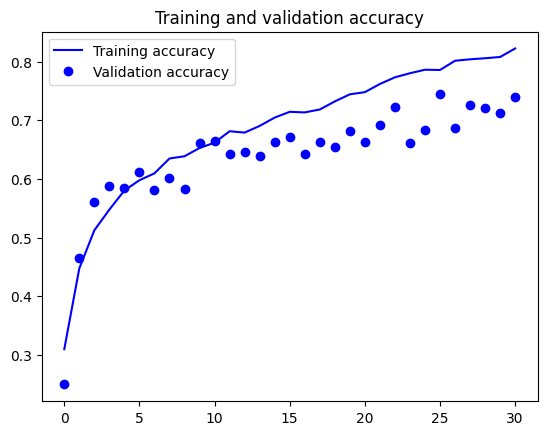

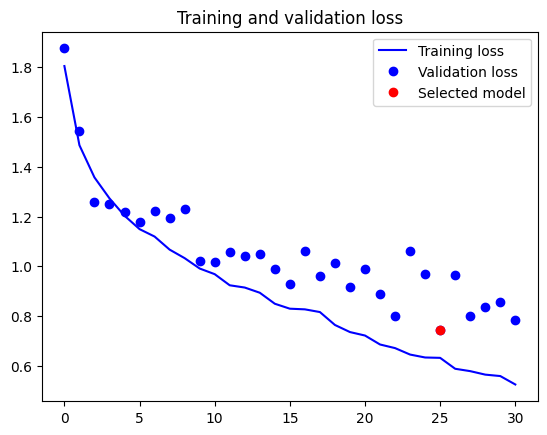

Lowest validation loss has been reached at epoch 25 with validation accuracy of 0.745


In [31]:
model_name = "naive_inception_module"
model_path = os.path.join(models_path, model_name)
compile_and_fit(model, model_name, model_path, learning_rate=0.0001)

19/19 [==============================] - 4s 187ms/step - loss: 0.6442 - accuracy: 0.7672
Classification report: 
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
[0 1 0 ... 7 0 0]
              precision    recall  f1-score   support

           0     0.2528    0.7755    0.3813       147
           1     0.9369    0.8543    0.8937      1112
           2     0.8684    0.4567    0.5986       289
           3     0.4937    0.3980    0.4407        98
           4     0.7538    0.8909    0.8167       165
           5     0.8259    0.5764    0.6789       288
           6     0.5256    0.6260    0.5714       131
           7     0.7375    0.6020    0.6629        98

    accuracy                         0.7255      2328
   macro avg     0.6743    0.6475    0.6305      2328
weighted avg     0.8083    0.7255    0.7458      2328



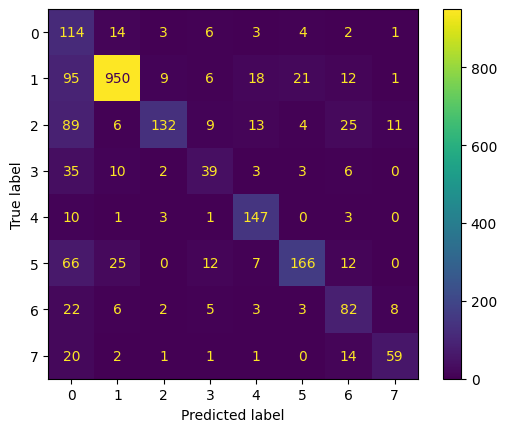

In [18]:
eval(tf.keras.models.load_model(os.path.join(model_path, model_name + '.h5')))

## Considerations

# Implementation of Complete Inception Module

In [38]:
def complete_inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
 conv1 = layers.Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)

 conv3 = layers.Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
 conv3 = layers.Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)

 conv5 = layers.Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
 conv5 = layers.Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)

 pool = layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
 pool = layers.Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)

 layer_out = layers.concatenate([conv1, conv3, conv5, pool], axis=-1)
 return layer_out

## Model definition

In [43]:
inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = resize_and_rescale(inputs)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(4,4), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(4, 4), strides=4)(x)
x = complete_inception_module(x, 64, 96, 128, 16, 32, 32)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = complete_inception_module(x, 128, 128, 192, 32, 96, 64)
x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(128)(x)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 224, 224, 3)  0           ['input_11[0][0]']               
                                                                                                  
 conv2d_86 (Conv2D)             (None, 56, 56, 32)   896         ['sequential_1[7][0]']           
                                                                                                  
 max_pooling2d_34 (MaxPooling2D  (None, 14, 14, 32)  0           ['conv2d_86[0][0]']        

Epoch 1/100
55/55 [==============================] - ETA: 0s - loss: 1.8273 - accuracy: 0.2967
Epoch 1: val_loss improved from inf to 1.65960, saving model to /content/drive/My Drive/project/models/complete_inception_module/complete_inception_module.h5
55/55 [==============================] - 20s 253ms/step - loss: 1.8273 - accuracy: 0.2967 - val_loss: 1.6596 - val_accuracy: 0.3807
Epoch 2/100
55/55 [==============================] - ETA: 0s - loss: 1.5244 - accuracy: 0.4420
Epoch 2: val_loss improved from 1.65960 to 1.43604, saving model to /content/drive/My Drive/project/models/complete_inception_module/complete_inception_module.h5
55/55 [==============================] - 15s 265ms/step - loss: 1.5244 - accuracy: 0.4420 - val_loss: 1.4360 - val_accuracy: 0.4886
Epoch 3/100
55/55 [==============================] - ETA: 0s - loss: 1.3715 - accuracy: 0.5072
Epoch 3: val_loss did not improve from 1.43604
55/55 [==============================] - 16s 260ms/step - loss: 1.3715 - accuracy: 0

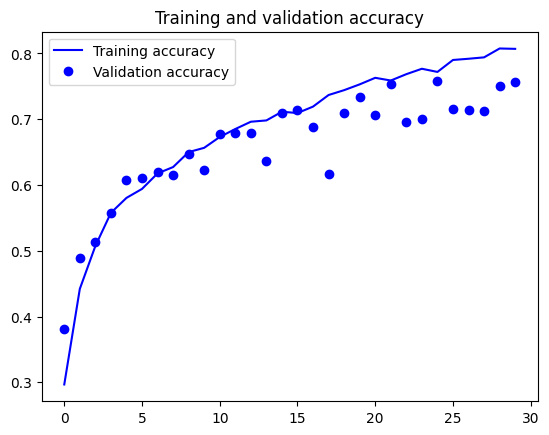

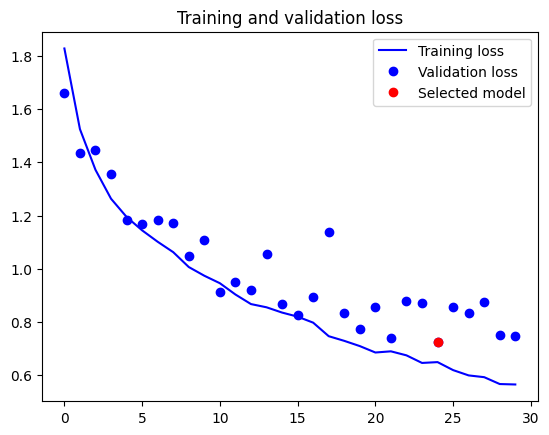

Lowest validation loss has been reached at epoch 24 with validation accuracy of 0.758


In [44]:
model_name = "complete_inception_module"
model_path = os.path.join(models_path, model_name)
compile_and_fit(model, model_name, model_path, learning_rate=0.0001)

19/19 [==============================] - 3s 168ms/step - loss: 0.6582 - accuracy: 0.7732
Classification report: 
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
[0 0 0 ... 0 3 3]
              precision    recall  f1-score   support

           0     0.2345    0.7959    0.3622       147
           1     0.9601    0.8004    0.8730      1112
           2     0.8588    0.5260    0.6524       289
           3     0.5667    0.5204    0.5426        98
           4     0.9000    0.7636    0.8262       165
           5     0.6967    0.8056    0.7472       288
           6     0.7313    0.3740    0.4949       131
           7     0.6316    0.6122    0.6218        98

    accuracy                         0.7204      2328
   macro avg     0.6974    0.6498    0.6400      2328
weighted avg     0.8216    0.7204    0.7487      2328



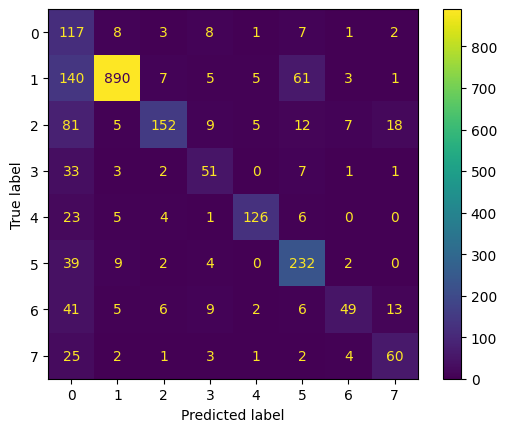

In [45]:
eval(tf.keras.models.load_model(os.path.join(model_path, model_name + '.h5')))

## Considerations